# Applications au S&P500

In [1]:
import pandas as pd
import plotly.express as px
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss, adfuller
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

import scipy.stats as scs
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import math
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import datetime as dt
import arch.data.sp500
import sys
from datetime import datetime, timedelta
from scipy.stats import pearsonr

## Importation et modifications

In [2]:
data = arch.data.sp500.load()
market = data["Adj Close"]

In [3]:
fig = px.line(market) #On créé une courbe 
fig.update_layout(title = "Données brut du S&P500 par jour entre 1999 et 2018",title_x = 0.5) #On lui donne un titre et on le centre
fig.show()

pct_change() ca fait comme diff(log()) et fois 100 pour mettre en pourcentage

In [4]:
returns = 100 * market.pct_change().dropna()
returns

Date
1999-01-05    1.358200
1999-01-06    2.214041
1999-01-07   -0.205133
1999-01-08    0.422136
1999-01-11   -0.879151
                ...   
2018-12-24   -2.711225
2018-12-26    4.959374
2018-12-27    0.856268
2018-12-28   -0.124158
2018-12-31    0.849248
Name: Adj Close, Length: 5030, dtype: float64

In [5]:
fig = px.line(returns) #On créé une courbe 
fig.update_layout(title = "Rendements du S&P500 par jour entre 1999 et 2018",title_x = 0.5) #On lui donne un titre et on le centre
fig.show()

## Test de stationnarité et check acf/pacf

### Test de stationnarité :

In [6]:
TestA = adfuller(returns) # Test ADF
print("ADF p-val : ", TestA[1]) 
TestK = kpss(returns) # Test KPSS
print("KPSS p-val : ", TestK[1])

ADF p-val :  1.8847790799642558e-29
KPSS p-val :  0.1


/usr/lib64/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Stationnaire !!!!!!!!!!!!!!!!!!!

### check acf et pacf

/usr/lib64/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



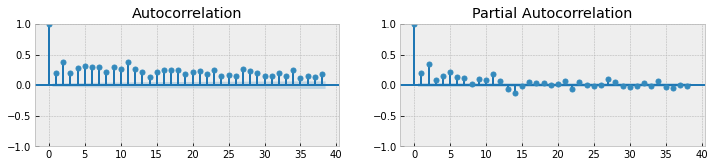

In [8]:
with plt.style.context("bmh"):
    fig = plt.figure(figsize=(12,2.25))
    layout = (1,2)
    acf_ax = plt.subplot2grid(layout, (0, 0), alpha=0.5)
    pacf_ax = plt.subplot2grid(layout, (0, 1), alpha=0.5)
    plot_acf(returns**2, ax=acf_ax)
    plot_pacf(returns**2, ax=pacf_ax) 

acf peut rien dire. pacf c'est de la merde, plein de pics significatif (le dernier que je compte après un lag de 40 c'est le 34e pics). Donc on test plein de modèle et on regarde leur AIC. C'est celui qui minimise qui est le best je crois. 

In [10]:
p=[1,2,3,4,5,6,7]
q=[0,1,2]
aic=pd.DataFrame(index=[1,2,3,4,5,6,7],columns=[0,1,2]) # declare un dataframe vide avec 7 lignes (pour les p)et 3 col (pour les q)

for i in range(1,8):
    for j in range(3):
        mod = arch_model(returns, vol="Garch", p=i, q=j)
        res=mod.fit(disp="off")
        aic.loc[i,j]=res.aic
        
aic

,0,1,2
1,15613.28536,13881.436954,13883.436954
2,14853.598648,13875.39208,13873.483431
3,14515.941724,13877.392079,13875.475552
4,14261.160188,13879.392079,13877.475553
5,14132.890046,13881.39208,13879.475552
6,14073.280024,13883.392079,13881.475552
7,14015.108815,13884.567381,13883.475552


Tente un Garch(1,1) pour l'exemple. On fait dans un premier temps une modélisation et prévisions pas à pas pour montrer comment on a procéder. Les prévisions se font par la commande python. Puis on compare avec les données calculée à la main.

In [40]:
p=2 ; q=2
mod = arch_model(returns, vol="Garch", p=p, q=q)
res = mod.fit(disp="off")
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6930.74
Distribution:                  Normal   AIC:                           13873.5
Method:            Maximum Likelihood   BIC:                           13912.6
                                        No. Observations:                 5030
Date:                Wed, Mar 01 2023   Df Residuals:                     5029
Time:                        13:05:16   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0572  1.151e-02      4.972  6.642e-07 [3.467e-02,7.980e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0321  8.849e-03      3.628  2.858e-04 [1.476e-02,4.944e-02]
alpha[1]       0.0675  2.173e-02      3.107  1.892e-03   [2.492e-02,  0.110]
alpha[2]       0.1115  2.356e-02      4.730  2.248e-06   [6.527e-02,  0.158]
beta[1]        0.2636      0.266      0.992      0.321     [ -0.257,  0.784]
beta[2]        0.5341      0.244      2.193  2.831e-02   [5.674e-02,  1.011]
============================================================================

Covariance estimator: robust
"""

In [41]:
mod_train = arch_model(returns, vol="Garch", p=p, q=q)
res_train = mod_train.fit(disp="off", last_obs="2017-12-31")
res_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6585.50
Distribution:                  Normal   AIC:                           13183.0
Method:            Maximum Likelihood   BIC:                           13221.8
                                        No. Observations:                 4779
Date:                Wed, Mar 01 2023   Df Residuals:                     4778
Time:                        13:05:18   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0550  1.181e-02      4.658  3.187e-06 [3.187e-02,7.816e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0268  7.750e-03      3.452  5.561e-04 [1.157e-02,4.195e-02]
alpha[1]       0.0490  1.975e-02      2.481  1.309e-02 [1.030e-02,8.771e-02]
alpha[2]       0.1082  2.387e-02      4.533  5.828e-06   [6.141e-02,  0.155]
beta[1]        0.3758      0.174      2.158  3.092e-02   [3.451e-02,  0.717]
beta[2]        0.4462      0.164      2.728  6.377e-03     [  0.126,  0.767]
============================================================================

Covariance estimator: robust
"""

In [42]:
forecasts = res_train.forecast(start="2018-01-01", reindex=False)
prediction = forecasts.variance
prediction=prediction.rename(columns={"h.1":"Python"})
prediction

,Python
Date,
2018-01-02,0.293008
2018-01-03,0.329701
2018-01-04,0.324329
2018-01-05,0.329435
2018-01-08,0.341353
...,...
2018-12-24,2.574766
2018-12-26,3.938451
2018-12-27,5.289485


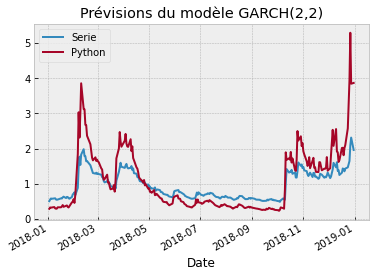

In [43]:
y_true=pd.DataFrame(res.conditional_volatility[-len(prediction):])
y_true=y_true.rename(columns={"cond_vol":"Serie"})

with plt.style.context("bmh"):
    fig=y_true.plot()
    prediction.plot(ax=fig)

    if q==0:
        plt.title(f"Prévisions du modèle ARCH({p})")
    else:
        plt.title(f"Prévisions du modèle GARCH({p},{q})")

mse

In [31]:
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(y_true, prediction )
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:",RMSE)

Root Mean Square Error: 0.5158821199865682


In [32]:

def min_rmse(last_obs):
    rmse=pd.DataFrame(index=[1,2,3,4,5,6,7],columns=[0,1,2])

    last_obs = datetime.strptime(last_obs, "%Y-%m-%d")
    day_start=last_obs + timedelta(days=1)
    day_start= day_start.strftime("%Y-%m-%d")
    
    for p in range(1,8):
        for q in range(3):
            mod = arch_model(returns, vol="Garch", p=p, q=q)
            res = mod.fit(disp="off")

            mod_train = arch_model(returns, vol="Garch", p=p, q=q)
            res_train = mod_train.fit(disp="off", last_obs=last_obs)

            forecasts = res_train.forecast(start=day_start, reindex=False)
            prediction = forecasts.variance
            prediction=prediction.rename(columns={"h.1":"Python"})
            y_true= res.conditional_volatility[-len(prediction):]

            MSE = mean_squared_error(y_true, prediction )
            RMSE = math.sqrt(MSE)
            rmse.loc[p,q]=RMSE

    return rmse

min_rmse("2017-12-31")

,0,1,2
1,0.871049,0.488549,0.488558
2,1.062168,0.514079,0.515882
3,1.103283,0.514063,0.515697
4,1.020929,0.51406,0.515704
5,0.906038,0.514071,0.515724
6,0.833973,0.514065,0.515704
7,0.789412,0.546893,0.528092


On peut voir que la RMSE minimale est pour un GARCH(1,1) à hauteur de 0.4885. Représentons alors les prévisions de ce modèles

Mise sous forme de $class$ pour le calcul à la main des prévisions

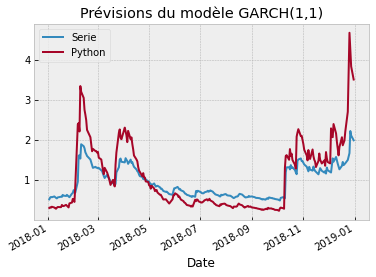

In [44]:
from code_projet import Prevision

p=1 ; q=1
last_obs="2017-12-31"
cond_var, y_true= Prevision(returns, p,q).forecast_calcul(last_obs)

with plt.style.context("bmh"):
    fig=y_true.plot()
    pred=cond_var.drop(["Calculer"],axis=1)
    pred.plot(ax=fig)

    if q==0:
        plt.title(f"Prévisions du modèle ARCH({p})")
    else:
        plt.title(f"Prévisions du modèle GARCH({p},{q})")

In [45]:
from code_projet import Prevision

def plot_modele(y_true, p, q, last_obs,ax):
    cond_var, y_true= Prevision(returns, p,q).forecast_calcul(last_obs)
    cond_var["Serie"]=list(y_true["Serie"])
    cond_var.plot(ax=ax)

    if q==0:
        ax.set_title(f"Prévisions du modèle ARCH({p})")
    else:
        ax.set_title(f"Prévisions du modèle GARCH({p},{q})")

In [46]:
cond_var

,Python,Calculer
Date,,
2018-01-02,0.300110,0.323764
2018-01-03,0.315421,0.337755
2018-01-04,0.308480,0.326834
2018-01-05,0.330229,0.353541
2018-01-08,0.311570,0.326405
...,...,...
2018-12-24,2.705965,2.763023
2018-12-26,4.681160,5.003688
2018-12-27,4.267176,4.471440


Pour mesurer la similitude entre les données calculées à la main et celles données par python.

In [47]:
corr,_= pearsonr(cond_var.iloc[:,0], cond_var.iloc[:,1])
print(f"{corr*100} % de corrélation")

99.90563892145731 % de corrélation


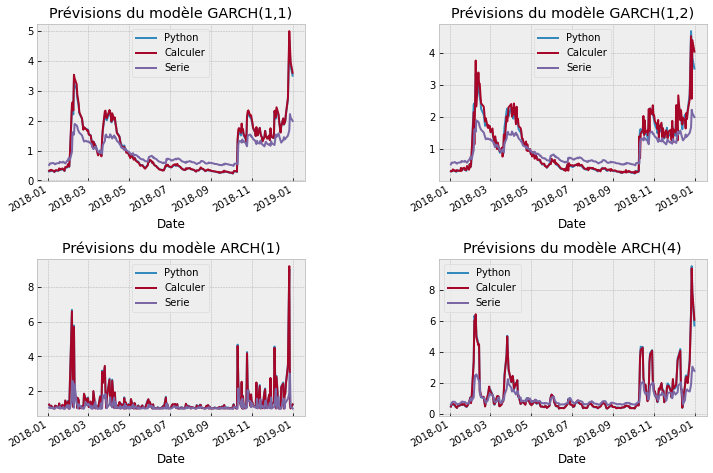

In [48]:
with plt.style.context("bmh"):
    fig = plt.figure(figsize=(12,8))
    layout = (2,2)
    g11_ax = plt.subplot2grid(layout, (0, 0))
    g12_ax = plt.subplot2grid(layout, (0, 1))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    a1_ax = plt.subplot2grid(layout, (1, 0))
    a4_ax = plt.subplot2grid(layout, (1, 1))

    plot_modele(y_true, 1,1,"2017-12-31",ax=g11_ax)
    plot_modele(y_true, 1,2,"2017-12-31",ax=g12_ax) 
    plot_modele(y_true, 1,0,"2017-12-31",ax=a1_ax)
    plot_modele(y_true, 4,0,"2017-12-31",ax=a4_ax)